<a href="https://colab.research.google.com/github/engineercha/engineercha/blob/master/%EC%A1%B8%ED%94%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1)데이터 불러오기

In [1]:
from scipy import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')
file_path = "/content/gdrive/My Drive/Colab Notebooks/data/vibration/vibration/"

Mounted at /content/gdrive/


In [3]:
global N, Fs, T
N=2000000
Fs=200000
T=10

## 2)데이터 구조 살피기

각 데이터에는 2개의 채널이 있습니다. 채널1은 가속도계에 의해 측정된 진동 데이터, 채널2는 인코더에 의해 측정된 회전속도 데이터입니다.

In [6]:
mat_file = io.loadmat(file_path+'H-A-1.mat')
mat_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Oct 09 15:18:50 2018',
 '__version__': '1.0',
 '__globals__': [],
 'Channel_1': array([[-0.00219944],
        [-0.0018706 ],
        [-0.00154175],
        ...,
        [ 0.00963905],
        [ 0.0093102 ],
        [ 0.00898136]]),
 'Channel_2': array([[4.18876708],
        [4.20060302],
        [4.20816487],
        ...,
        [0.03700339],
        [0.03634584],
        [4.14010822]])}

## 3) 데이터 전처리

In [4]:
raw=[]
seg=[]
file_names=['H-A-1.mat','H-A-2.mat','H-A-3.mat','H-B-1.mat','H-B-2.mat','H-B-3.mat','H-C-1.mat','H-C-2.mat','H-C-3.mat','H-D-1.mat','H-D-2.mat','H-D-3.mat','I-A-1.mat','I-A-2.mat','I-A-3.mat','I-B-1.mat','I-B-2.mat','I-B-3.mat','I-C-1.mat','I-C-2.mat','I-C-3.mat','I-D-1.mat','I-D-2.mat','I-D-3.mat','O-A-1.mat','O-A-2.mat','O-A-3.mat','O-B-1.mat','O-B-2.mat','O-B-3.mat','O-C-1.mat','O-C-2.mat','O-C-3.mat','O-D-1.mat','O-D-2.mat','O-D-3.mat','B-A-1.mat','B-A-2.mat','B-A-3.mat','B-B-1.mat','B-B-2.mat','B-B-3.mat','B-C-1.mat','B-C-2.mat','B-C-3.mat','B-D-1.mat','B-D-2.mat','B-D-3.mat', 'C-A-1.mat','C-A-2.mat','C-A-3.mat','C-B-1.mat','C-B-2.mat','C-B-3.mat','C-C-1.mat','C-C-2.mat','C-C-3.mat','C-D-1.mat','C-D-2.mat','C-D-3.mat']

for i in range(60):
  mat_file = io.loadmat(file_path+file_names[i])['Channel_1']
  raw.append(mat_file)
  for j in range(1000):
    seg.append(mat_file[2000*j:2000*(j+1)])

raw=np.array(raw).reshape(60,2000000)
seg=np.array(seg).reshape(60000,2000)

#길이가 200만인 1개의 데이터를 길이가 2천인 1000개의 데이터로 분할함
#기존의 데이터는 10초동안 측정된 데이터이므로 분할된 데이터는 1/100초에 해당함

In [7]:
raw_fft=[]

for i in range(60):
  fft=np.fft.fft(raw[i])/N
  raw_fft.append(fft)

raw_fft=np.array(raw_fft)

In [8]:
seg_fft=[]

for i in range(60000):
  fft=np.fft.fft(seg[i])/2000
  seg_fft.append(fft[:1000])

seg_fft=np.array(seg_fft)

# 신호를 np.fft.fft() 함수로 푸리에 변환한다. 이때, 함수의 반환값을 신호의 길이로 나누어 normalization 해주어야 한다.
# magnitude를 얻기 위해 함수의 반환값에 abs()를 취한다.
# 푸리에 변환을 통해 주파수에 따른 magnitude와 angle을 구할 수 있는데, 반환값이 복소수 타입이기 때문이다.
# fft한 결과는 좌우대칭하므로 left에 해당하는 부분만 idexing 하여 데이터 크기를 줄인다.

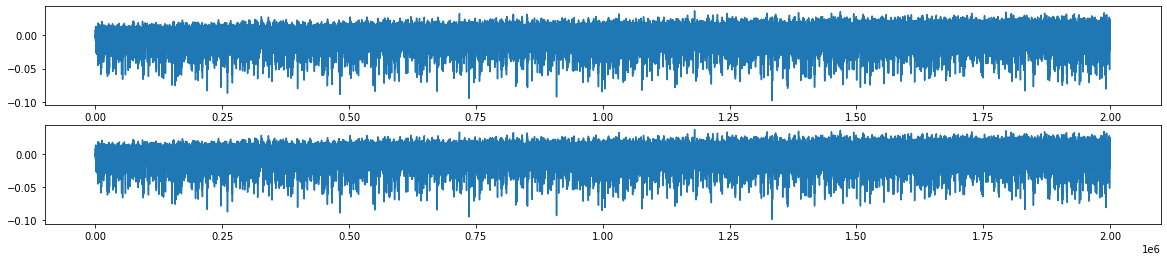

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(2,1,1); plt.plot(raw[0])
plt.subplot(2,1,2); plt.plot(np.hstack(seg[0:1000]))
plt.show()

## 4)학습

#### 선형회귀 모델(실패)

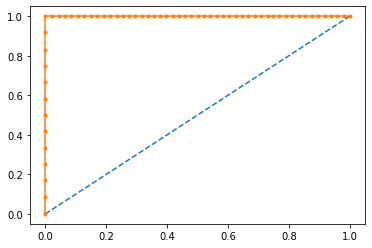

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

scaler=StandardScaler()
x_train, x_test=scaler.fit_transform(X_train), scaler.transform(X_test)

clf=LogisticRegression()
clf.fit(x_train, y_train)

pred=clf.predict(x_test)
prob=clf.predict_proba(x_test)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, prob[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()


In [ ]:
confusion_matrix(y_test, pred)

array([[12028,     0],
       [    0,  2972]])

크기가 784인 이미지와 실제 숫자값을 갖는 데이터가 7만개인 mnist와 비슷하게

크기가 1000인 신호와 실제 정상여부 값을 갖는 데이터 6만개


In [ ]:
df['class'].value_counts()

0    48000
1    12000
Name: class, dtype: int64

#### 딥러닝 모델

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

In [196]:
x=pd.DataFrame(abs(seg_fft))
y=np.concatenate([np.ones(12000, int), np.zeros(48000, int)]) #정상은 1, 고장은 0
df=x
df['class']=y

In [197]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns!='class'], df['class'], random_state=0)

model10=Sequential()
model10.add(Dense(800, input_dim=1000, activation='relu'))
model10.add(Dense(250, activation='relu'))
model10.add(Dense(1, activation='sigmoid')) #이진분류에 가장 많이 사용되는 활성화함수

model10.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [198]:
history12=model10.fit(X_train, y_train, validation_split=0.25, epochs=100, batch_size=600)

Epoch 1/100
57/57 [==============================] - 5s 73ms/step - loss: 0.4546 - accuracy: 0.7990 - val_loss: 0.3820 - val_accuracy: 0.7976
Epoch 2/100
57/57 [==============================] - 4s 73ms/step - loss: 0.3394 - accuracy: 0.8228 - val_loss: 0.3094 - val_accuracy: 0.8989
Epoch 3/100
57/57 [==============================] - 4s 68ms/step - loss: 0.2863 - accuracy: 0.8679 - val_loss: 0.2914 - val_accuracy: 0.8968
Epoch 4/100
57/57 [==============================] - 4s 72ms/step - loss: 0.2457 - accuracy: 0.8988 - val_loss: 0.2091 - val_accuracy: 0.9124
Epoch 5/100
57/57 [==============================] - 4s 70ms/step - loss: 0.2112 - accuracy: 0.9239 - val_loss: 0.1673 - val_accuracy: 0.9729
Epoch 6/100
57/57 [==============================] - 4s 71ms/step - loss: 0.1801 - accuracy: 0.9400 - val_loss: 0.1509 - val_accuracy: 0.9713
Epoch 7/100
57/57 [==============================] - 4s 74ms/step - loss: 0.1511 - accuracy: 0.9501 - val_loss: 0.1618 - val_accuracy: 0.9436
Epoch 

## 5)정확도, 정밀도 계산

In [249]:
def acc(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  #plt.title('Model accuracy')
  #plt.xlabel('Epoch')
  #plt.ylabel('Accuracy')
  plt.ylim(0.98,1)
  plt.legend(['Train', 'Test'], loc='upper left')

def res(model):
  pred=model.predict(X_test)
  pred=np.array([0 if i<0.5 else 1 for i in pred])
  print(confusion_matrix(y_test, pred))
  print(model.evaluate(X_test, y_test))
  print(metrics.recall_score(y_test, pred))
  return pred

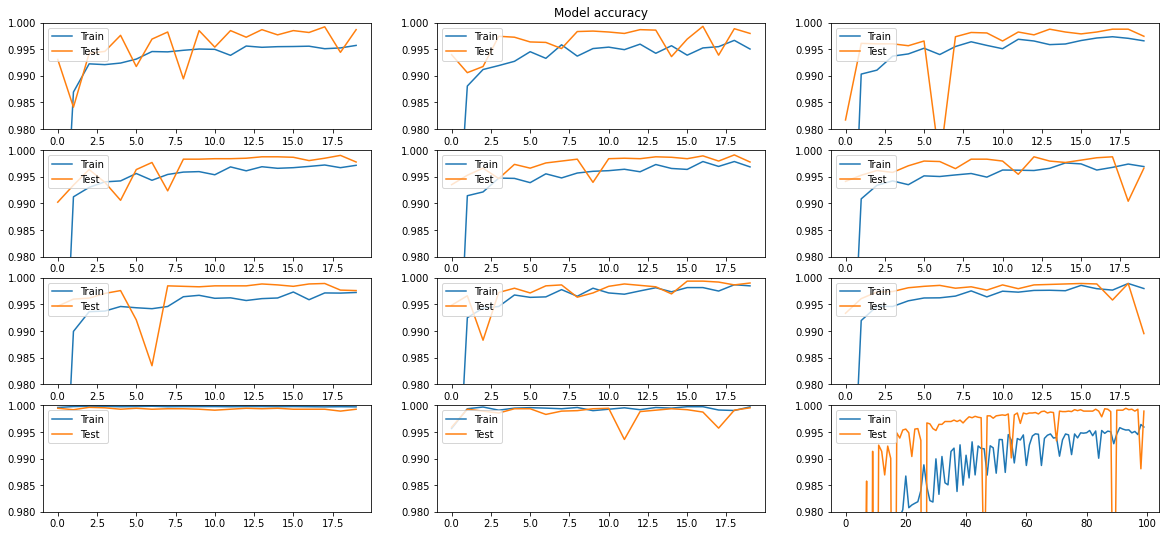

In [251]:
plt.figure(figsize=(20,9))
plt.subplot(4,3,1); acc(history1)
plt.subplot(4,3,2); acc(history2); plt.title('Model accuracy')
plt.subplot(4,3,3); acc(history3)
plt.subplot(4,3,4); acc(history4)
plt.subplot(4,3,5); acc(history5)
plt.subplot(4,3,6); acc(history6)
plt.subplot(4,3,7); acc(history7)
plt.subplot(4,3,8); acc(history8)
plt.subplot(4,3,9); acc(history9)
plt.subplot(4,3,10); acc(history10)
plt.subplot(4,3,11); acc(history11)
plt.subplot(4,3,12); acc(history12)

In [209]:
pred=res(model10)

#confusion matrix의 구조는 TN(고장예측 실제고장), FP(정상예측 실제고장)
#                          FN(고장예측 실제정상), TP(정상예측 실제정상)
#고장을 정상으로 잘못 예측한 경우가 많다. 이러면 의미가 없다.

469/469 [==============================] - 2s 5ms/step
[[12010     3]
 [   11  2976]]
469/469 [==============================] - 3s 7ms/step - loss: 0.0043 - accuracy: 0.9991
[0.004294762387871742, 0.9990666508674622]
0.9963173752929361


In [126]:
temp=list(y_test)
print(temp.count(0), temp.count(1))

12013 2987


## 6)오분류 시각화

In [241]:
def wrong(F_):
  plt.figure(figsize=(24,4))
  for i in range(len(F_)):
    idx=F_[i]
    plt.subplot(1,len(F_),i+1)
    plt.plot(abs(seg_fft[idx]))
    a=list(y_test)[idx]
    b=list(pred)[idx]
    plt.title(str(a)+'(predict:'+str(b)+')', color="red")

In [237]:
FP=[i for i in range(15000) if list(y_test)[i]==0 and list(pred)[i]==1]

In [239]:
FN=[i for i in range(15000) if list(y_test)[i]==1 and list(pred)[i]==0]

[3031, 7234, 7975]

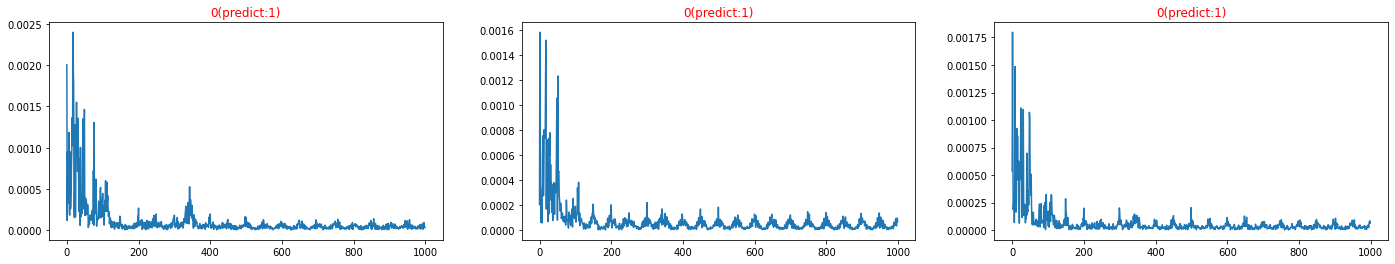

In [246]:
wrong(FP); FP

[187, 1504, 1531, 2574, 2812, 10463, 10674, 11038, 12840, 13421, 13758]

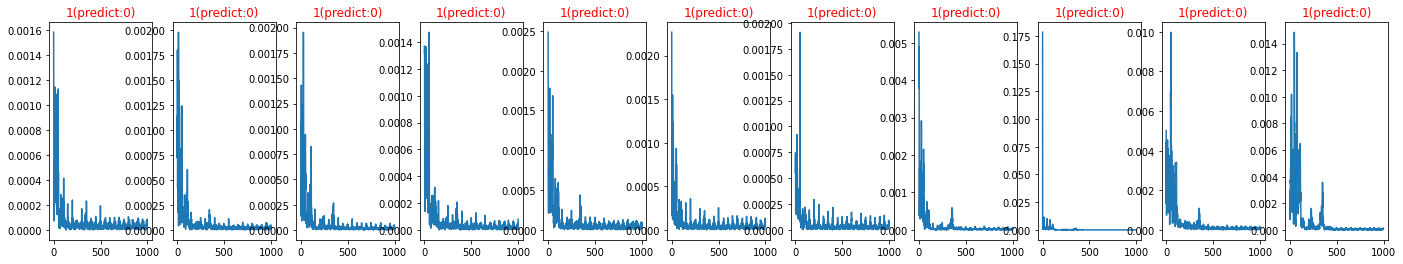

In [247]:
wrong(FN); FN

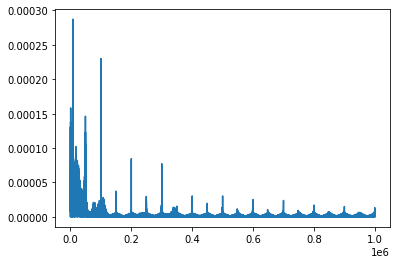

In [ ]:
mat_file=io.loadmat(file_path+'H-C-3.mat')['Channel_1'].reshape(N)
mat_fft=(np.fft.fft(mat_file)/N)[:N//2]
plt.plot(abs(mat_fft))

## STFT(short-time fourier transform)

## 7)시각화하기

#### 베어링 상태별 그래프

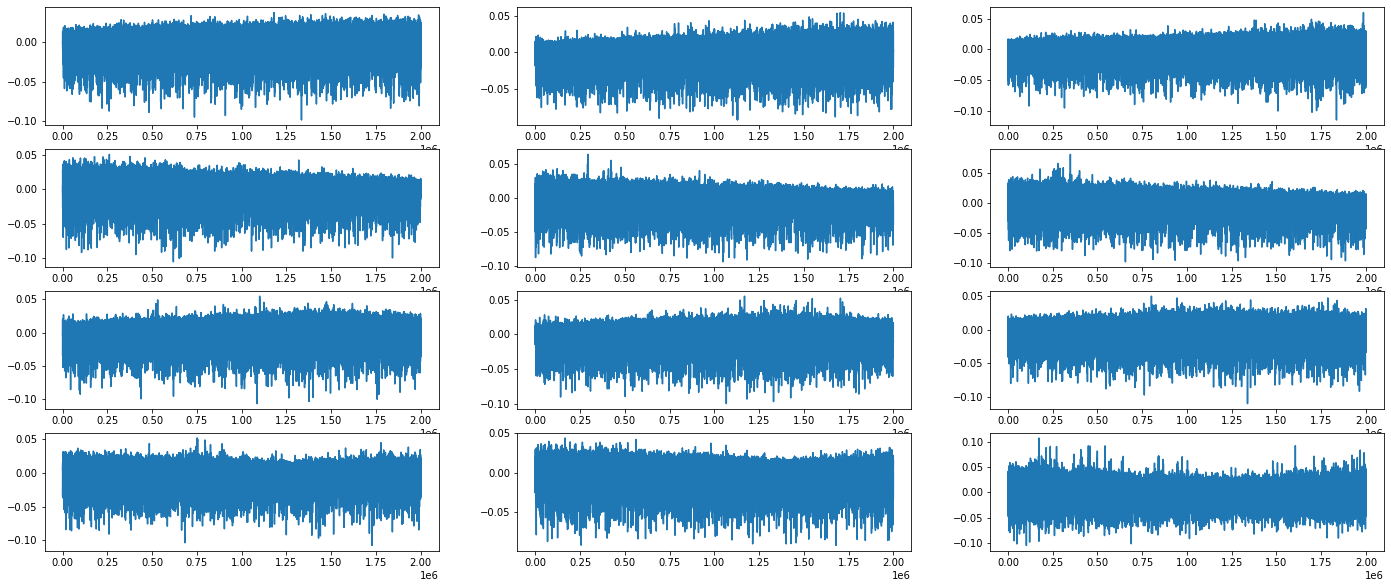

In [ ]:
#healthy bearing

plt.figure(figsize=(24,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(range(2000000), raw[i])
  #plt.xticks([0,200000,400000,600000,800000,1000000,1200000,1400000,1600000,1800000,2000000], [0,1,2,3,4,5,6,7,8,9,10])
  #plt.xlabel('time(s)')

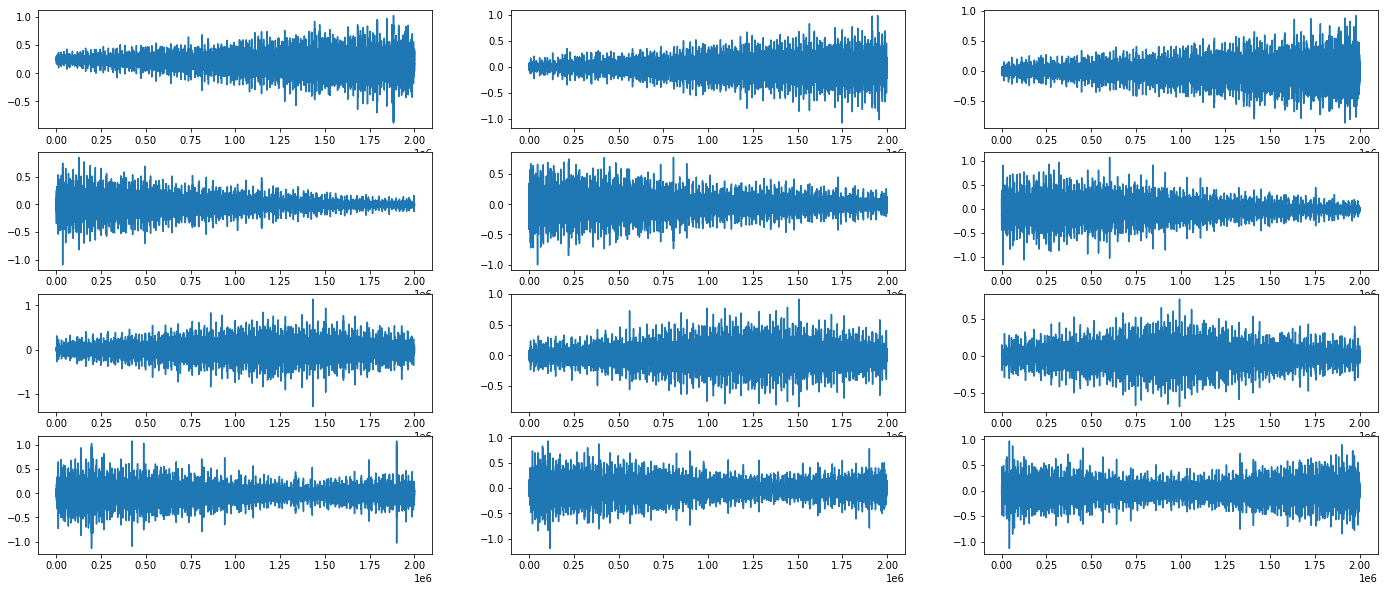

In [ ]:
#inner race fault 

plt.figure(figsize=(24,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(range(2000000), raw[i+12])

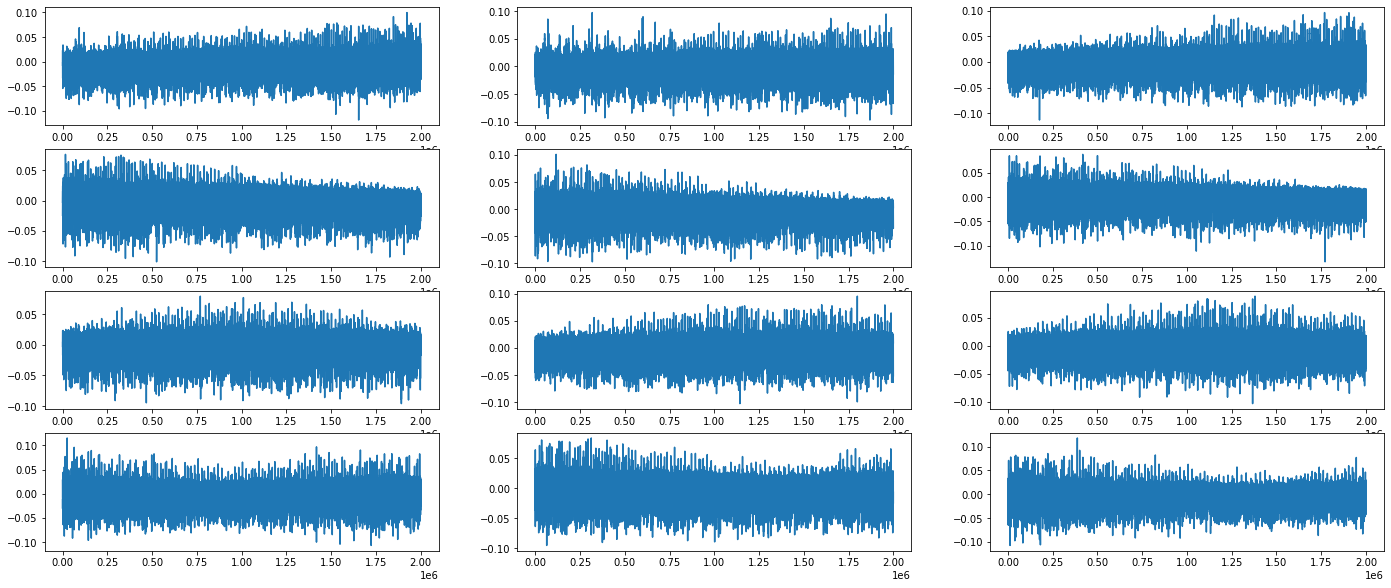

In [ ]:
#outer race fault

plt.figure(figsize=(24,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(range(2000000), raw[i+24])

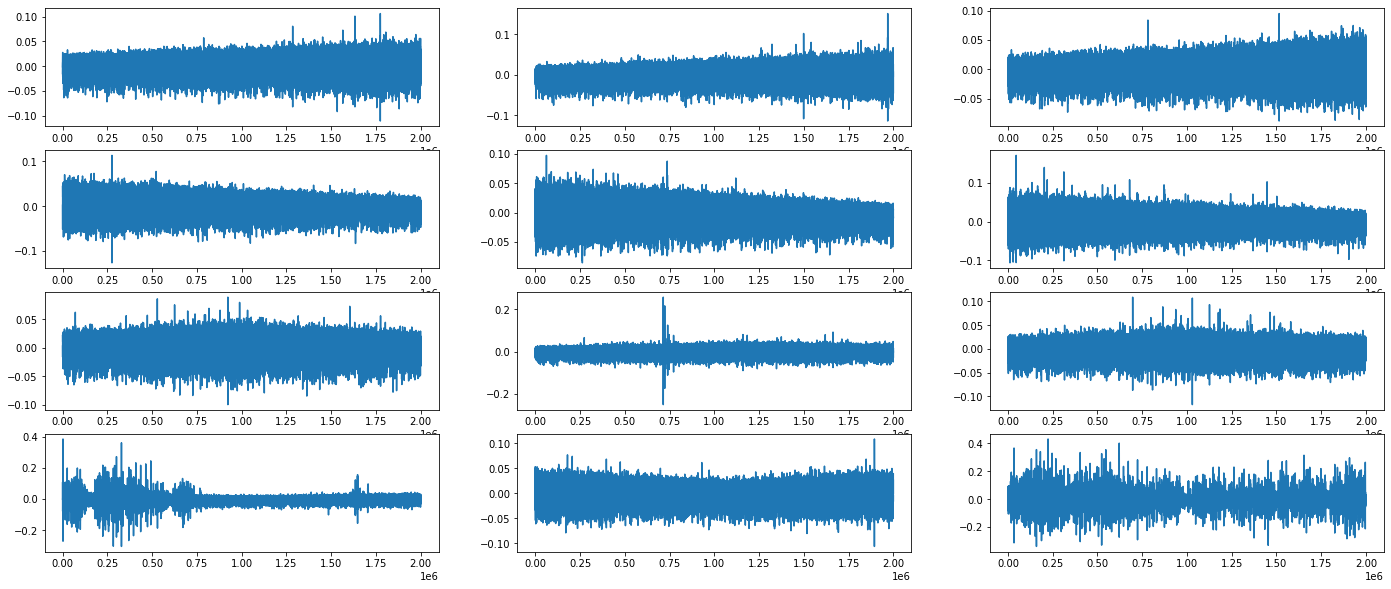

In [ ]:
#ball fault

plt.figure(figsize=(24,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(range(2000000), raw[i+36])

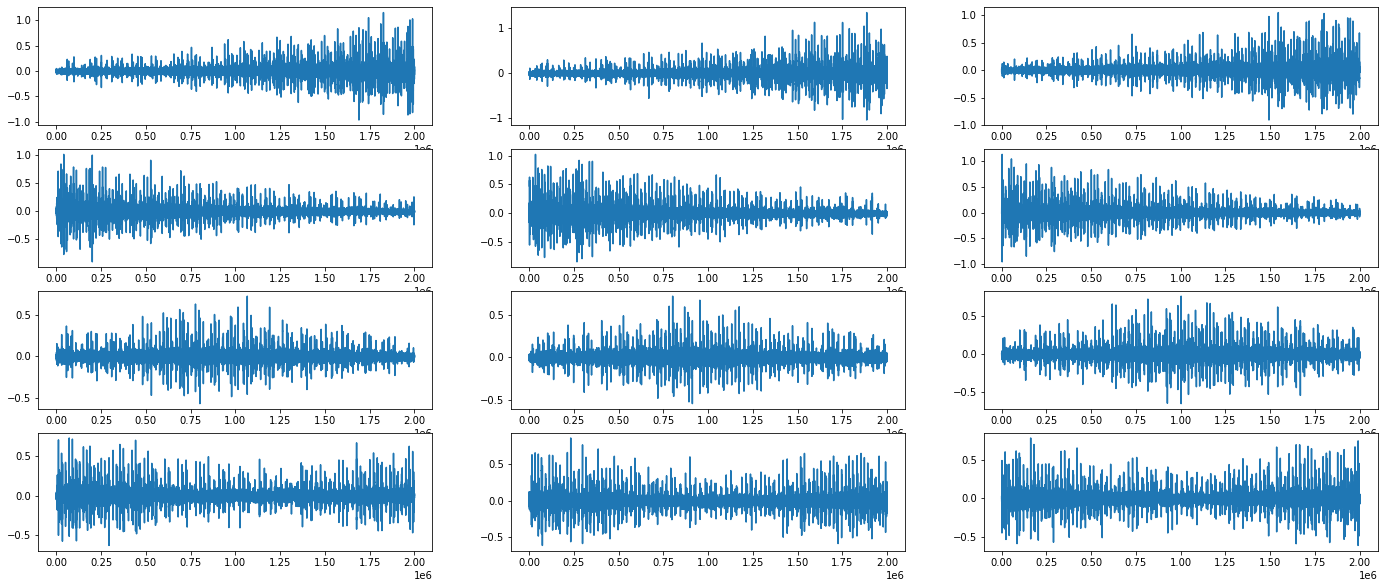

In [ ]:
#combination of faults

plt.figure(figsize=(24,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(range(2000000), raw[i+48])

#### 베어링 상태별 FFT 그래프

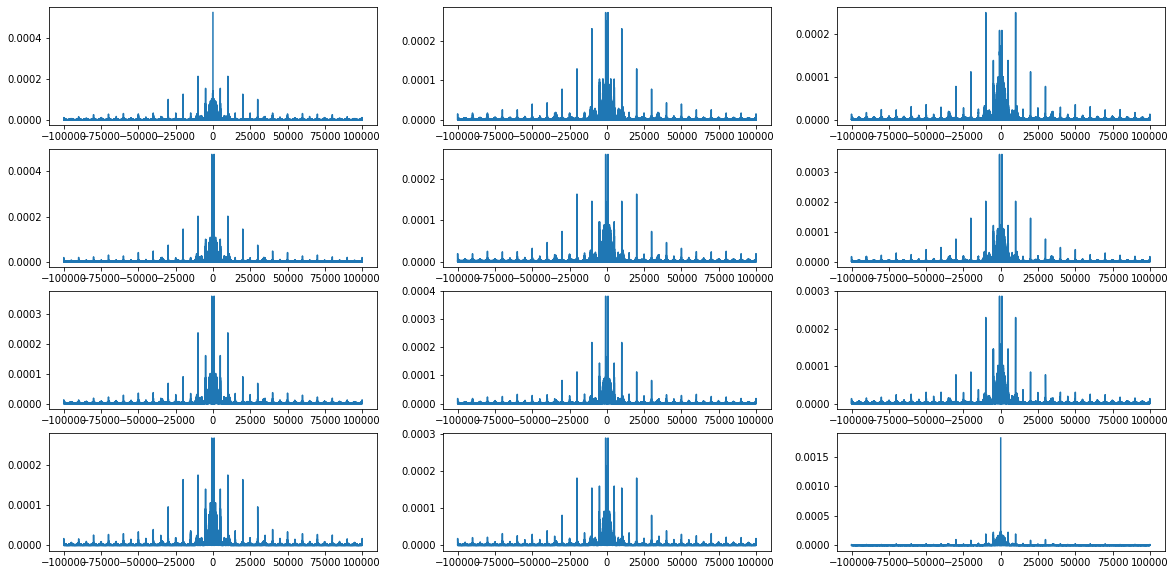

In [ ]:
#healthy bearing

plt.figure(figsize=(20,10))
freq=np.fft.fftfreq(N, 1/Fs)
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(freq, abs(raw_fft[i]))

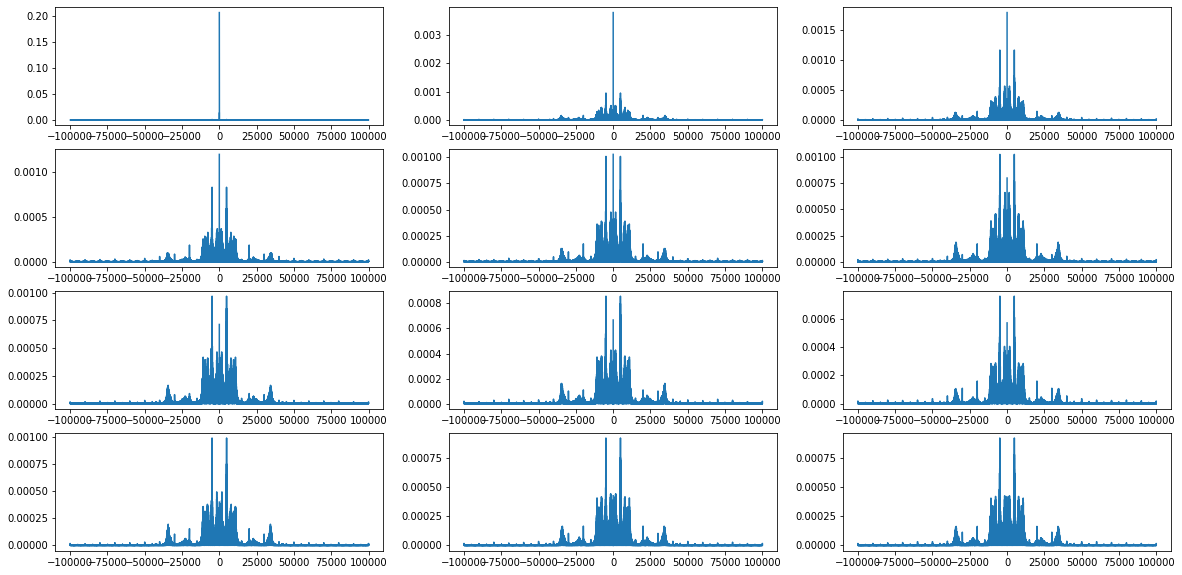

In [ ]:
#inner race fault 

plt.figure(figsize=(20,10))
freq=np.fft.fftfreq(N, 1/Fs)
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(freq, abs(raw_fft[i+12]))

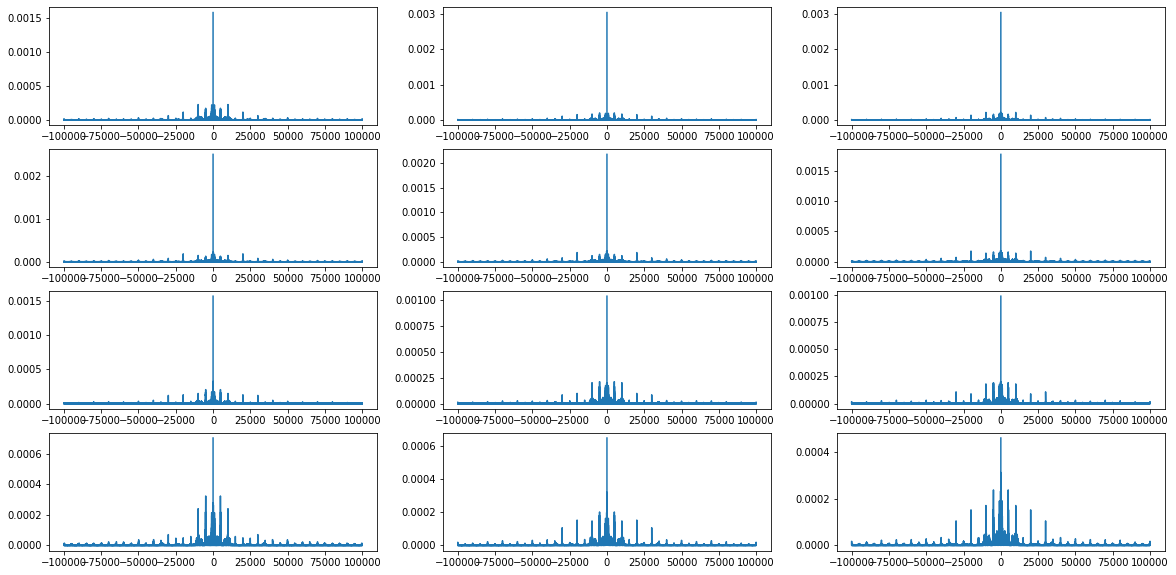

In [ ]:
#outer race fault

plt.figure(figsize=(20,10))
freq=np.fft.fftfreq(N, 1/Fs)
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(freq, abs(raw_fft[i+24]))

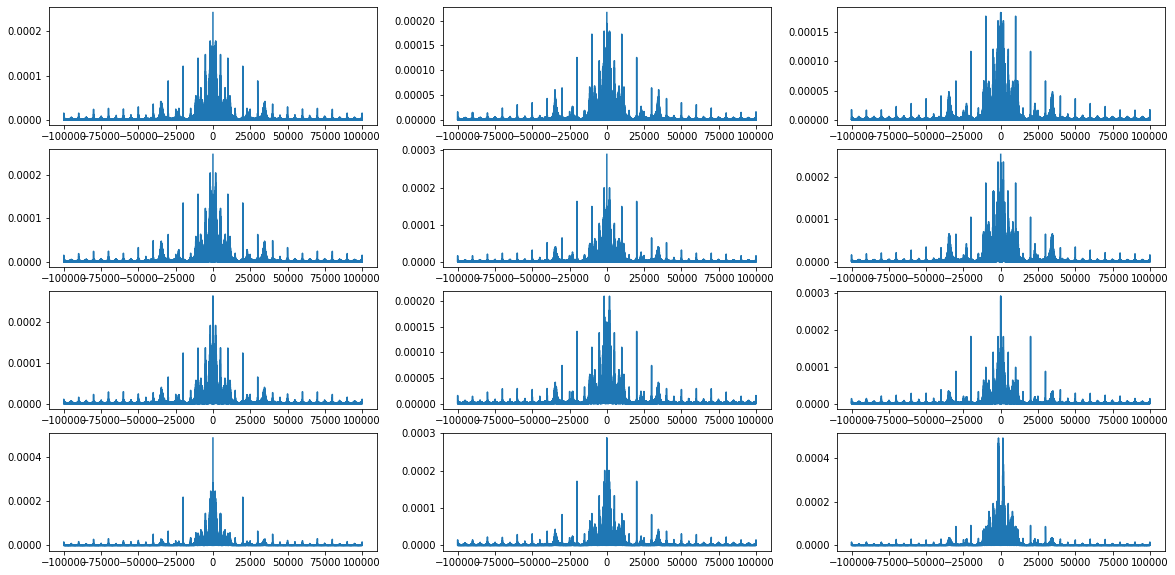

In [ ]:
#ball fault

plt.figure(figsize=(20,10))
freq=np.fft.fftfreq(N, 1/Fs)
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(freq, abs(raw_fft[i+36]))

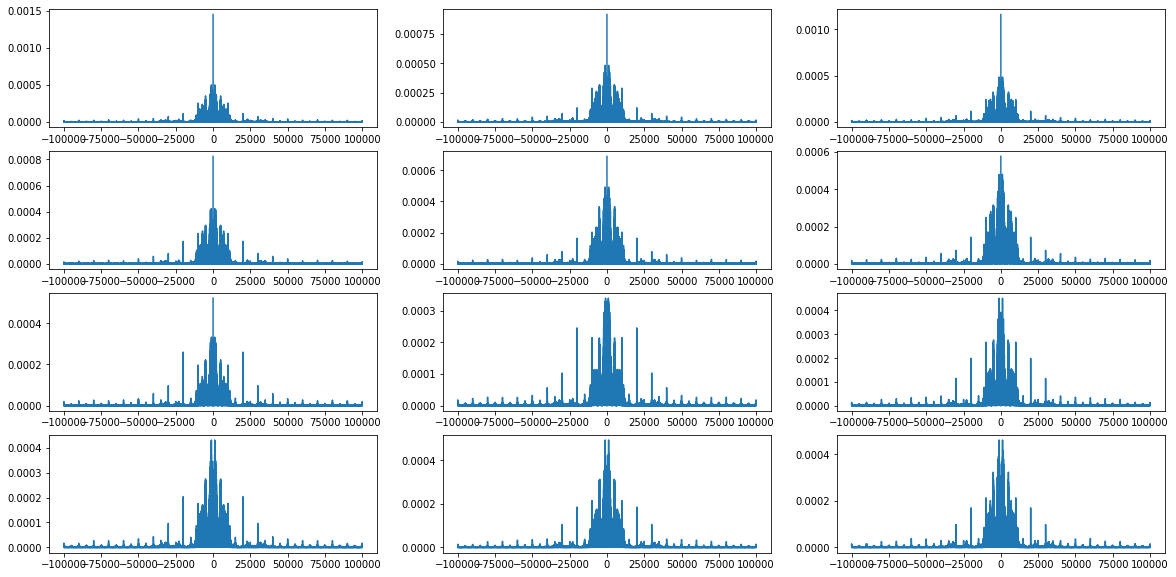

In [ ]:
#combination of faults

plt.figure(figsize=(20,10))
freq=np.fft.fftfreq(N, 1/Fs)
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(freq, abs(raw_fft[i+48]))

#### 베어링 속도별 평균 FFT 그래프

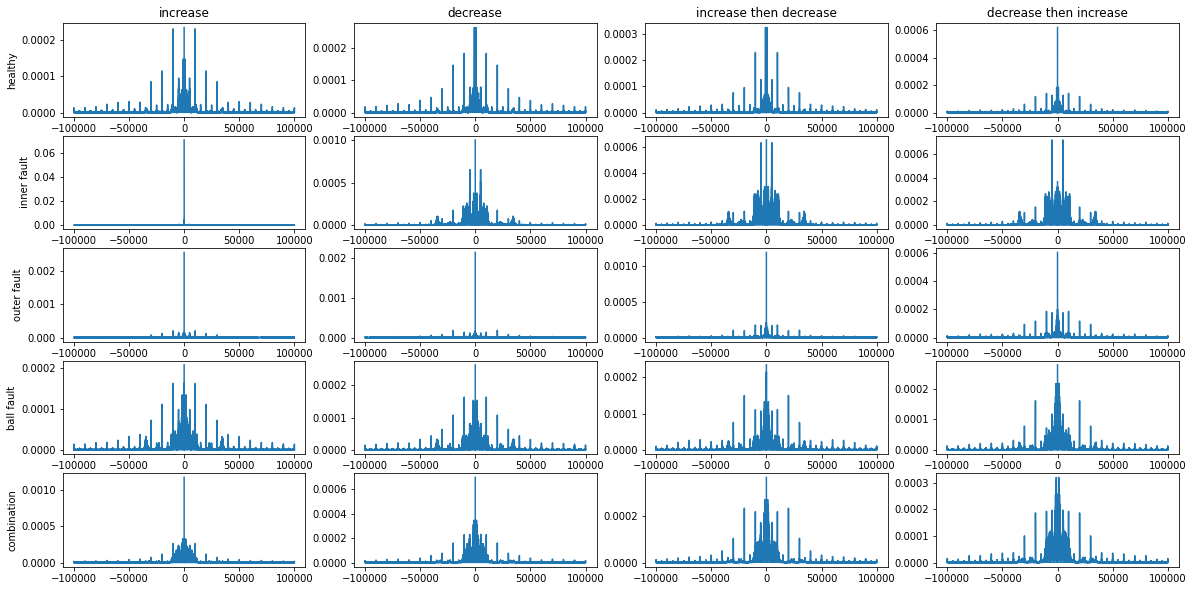

In [ ]:
plt.figure(figsize=(20,10))

for i in range(20):
  plt.subplot(5,4,i+1)
  plt.plot(freq, np.average(abs(raw_fft[3*i:3*(i+1)]), axis=0))

  if i==0: plt.title('increase'); plt.ylabel('healthy')
  elif i==1: plt.title('decrease')
  elif i==2: plt.title('increase then decrease')
  elif i==3: plt.title('decrease then increase')
  elif i==4: plt.ylabel('inner fault')
  elif i==8: plt.ylabel('outer fault')
  elif i==12: plt.ylabel('ball fault')
  elif i==16: plt.ylabel('combination')
  
plt.show()

## 전에 쓰던 전처리 코드

In [ ]:
#50초 정도 소요
raw=[]
file_names=['H-A-1.mat','H-A-2.mat','H-A-3.mat','H-B-1.mat','H-B-2.mat','H-B-3.mat','H-C-1.mat','H-C-2.mat','H-C-3.mat','H-D-1.mat','H-D-2.mat','H-D-3.mat','I-A-1.mat','I-A-2.mat','I-A-3.mat','I-B-1.mat','I-B-2.mat','I-B-3.mat','I-C-1.mat','I-C-2.mat','I-C-3.mat','I-D-1.mat','I-D-2.mat','I-D-3.mat','O-A-1.mat','O-A-2.mat','O-A-3.mat','O-B-1.mat','O-B-2.mat','O-B-3.mat','O-C-1.mat','O-C-2.mat','O-C-3.mat','O-D-1.mat','O-D-2.mat','O-D-3.mat','B-A-1.mat','B-A-2.mat','B-A-3.mat','B-B-1.mat','B-B-2.mat','B-B-3.mat','B-C-1.mat','B-C-2.mat','B-C-3.mat','B-D-1.mat','B-D-2.mat','B-D-3.mat', 'C-A-1.mat','C-A-2.mat','C-A-3.mat','C-B-1.mat','C-B-2.mat','C-B-3.mat','C-C-1.mat','C-C-2.mat','C-C-3.mat','C-D-1.mat','C-D-2.mat','C-D-3.mat']

for i in range(60):
  mat_file = io.loadmat(file_path+file_names[i])['Channel_1'].reshape(2000000)
  raw.append(mat_file)

raw=np.array(raw)

In [ ]:
#5초 정도 소요
raw_fft=[]

for i in range(60):
  fft=np.fft.fft(raw[i])/N
  raw_fft.append(fft)

raw_fft=np.array(raw_fft)

In [ ]:
raw_100=[]

for i in range(60):
  res=raw[i].reshape(1000,2000)
  for j in range(1000):
    raw_100.append(res[j])

raw_100=np.array(raw_100)

In [ ]:
raw_fft_100=[]

for i in range(60000):
  fft=np.fft.fft(raw_100[i])/2000
  raw_fft_100.append(fft)

raw_fft_100=np.array(raw_fft_100)

## 전에 쓰던 함수

In [ ]:
def show(data):
    plt.figure(figsize=(20,5))
    plt.plot(range(2000000), data)

In [ ]:
def during(data,a,b):
    start=a
    end=b
    new_data=data[int(200000*a):int(200000*b)]

    plt.figure(figsize=(20,5))
    plt.plot(range(int(200000*(b-a))), new_data)
    plt.show()

In [ ]:
def fft(data, n=N):
    time=np.arange(0,10,1/Fs)
    Y=np.fft.fft(data)/N
    Y_mag=np.abs(Y)
    
    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.plot(time[:n], data[:n])
    plt.subplot(2,1,2)
    plt.stem(Y_mag[:n])
    plt.show()